In [1]:
feature_index = 4

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
ls

gdrive/  sample_data/


In [4]:
cd gdrive/MyDrive/

/content/gdrive/MyDrive


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
!rm -rf face-landmark-detection
!git clone --branch part2 https://github.com/mariaafara/face-landmark-detection.git

Cloning into 'face-landmark-detection'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 203 (delta 79), reused 166 (delta 43), pack-reused 0
Receiving objects: 100% (203/203), 4.95 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (79/79), done.


In [7]:
cd face-landmark-detection/

/content/gdrive/MyDrive/face-landmark-detection


In [8]:
import os
os.environ['KAGGLE_USERNAME'] = "mariaafara" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file
# Crearting a Client to host the Kaggle API
!pip install -q kaggle
!kaggle datasets download mariaafara/Facial-Landmarks
!unzip Facial-Landmarks.zip # -d facial-keypoints-detection

 97% 137M/141M [00:01<00:00, 63.5MB/s]
100% 141M/141M [00:01<00:00, 78.7MB/s]
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
Archive:  Facial-Landmarks.zip
  inflating: dic_missing_data.pkl    
  inflating: dic_train_data.pkl      


In [9]:
ls

data_preparation.ipynb  images/                     src/
dic_missing_data.pkl    label_missing_values.ipynb  train_models_notebooks/
dic_train_data.pkl      prediction_model.ipynb
Facial-Landmarks.zip    README.md


In [10]:
from src.utils import *
dic_non_missing_data = load_from_pickle("dic_train_data.pkl")
features = list(dic_non_missing_data.keys())
feature_name = features[feature_index]
os.environ["EPOCHS"] = "100"
os.environ["RGB_CHANNELS"] = "false"
os.environ["PATIENCE_EARLY_STOPPING"] = "8"
# os.environ["PATIENCE_LR"] = "5"
path = F"/content/gdrive/My Drive/saved/"
os.environ["TRAIN_SCALER_PATH"] = "{}_scaler.pkl".format(path+feature_name)
os.environ["WEIGHT_PATH"] = "{}/weights/{}.ckpt".format(path+feature_name, feature_name)
os.environ["FEATURES_DIMENSIONS"] = "2"
os.environ["MODEL_PATH"] = "{}/model".format(path+feature_name)

In [11]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from src.config import prediction_model_config as config
from src.model.simple_model import MySimpleModel
from src.train import fit_model, compile_model
from src.data_preparation import DataGenerator
from IPython.display import clear_output
pd.options.mode.chained_assignment = None  # default='warn'

In [12]:
# !pip install jedi==0.17.2

In [13]:
dic_non_missing_data[feature_name].head()

,right_eye_inner_corner_x,right_eye_inner_corner_y,Image
0,36.356571,37.389402,"[[238, 236, 237, 238, 240, 240, 239, 241, 241,..."
1,36.034723,34.361532,"[[219, 215, 204, 196, 204, 211, 212, 200, 180,..."
2,37.678105,36.320968,"[[144, 142, 159, 180, 188, 188, 184, 180, 167,..."
3,37.618643,38.754115,"[[193, 192, 193, 194, 194, 194, 193, 192, 168,..."
4,36.982380,39.094852,"[[147, 148, 160, 196, 215, 214, 216, 217, 219,..."


In [14]:
df = dic_non_missing_data[feature_name]
df_train, df_test_val = split_data(df, test_size=0.3)
df_val, df_test = split_data(df_test_val, test_size=0.1)
print(df.shape, df_train.shape, df_val.shape, df_test.shape)

# fit the MinMaxScaler using the training data and then apply the scaler on the testing data before the prediction.
scaler = create_scaler(df_train.iloc[:,:-1])
save_to_pickle(scaler, config.TRAIN_SCALER_PATH)

train_generator = DataGenerator(df_train, 
                                batch_size=config.BATCH_SIZE,
                                augment= config.AUGMENT_TRAIN,
                                rgb_channels= config.RGB_CHANNELS,
                                normalize_image=config.NORMALIZE_IMAGE,
                                normalize_coordinates=config.NORMALIZE_COORDINATES, 
                                scaler=scaler)

val_generator =  DataGenerator(df_test,
                               batch_size=config.BATCH_SIZE,
                               augment=config.AUGMENT_TRAIN,
                               shuffle=False, 
                               rgb_channels=config.RGB_CHANNELS, 
                               normalize_image=config.NORMALIZE_IMAGE,
                               normalize_coordinates=config.NORMALIZE_COORDINATES,
                               scaler=train_generator.scaler)

test_generator =  DataGenerator(df_test,
                               batch_size=config.BATCH_SIZE,
                               augment=config.AUGMENT_VAL,
                               shuffle=False, 
                               rgb_channels=config.RGB_CHANNELS, 
                               normalize_image=config.NORMALIZE_IMAGE,
                               normalize_coordinates=config.NORMALIZE_COORDINATES,
                               scaler=train_generator.scaler)

(2268, 3) (1587, 3) (612, 3) (69, 3)


In [15]:
my_model = MySimpleModel(config.IMAGE_SHAPE, config.FEATURES_DIMENSIONS)
compile_model(my_model, optimizer="adam", loss='mean_squared_error', metrics=['mae'])
my_model, history = fit_model(my_model, config.EPOCHS, train_generator, val_generator, config.WEIGHT_PATH)

Epoch 1/100
49/49 [==============================] - 5s 53ms/step - loss: 0.1174 - mae: 0.2537 - val_loss: 0.0239 - val_mae: 0.1172

Epoch 00001: val_loss improved from inf to 0.02386, saving model to /content/gdrive/My Drive/saved/right_eye_inner_corner/weights/right_eye_inner_corner.ckpt
Epoch 2/100
49/49 [==============================] - 2s 48ms/step - loss: 0.0311 - mae: 0.1307 - val_loss: 0.0192 - val_mae: 0.1058

Epoch 00002: val_loss improved from 0.02386 to 0.01915, saving model to /content/gdrive/My Drive/saved/right_eye_inner_corner/weights/right_eye_inner_corner.ckpt
Epoch 3/100
49/49 [==============================] - 2s 47ms/step - loss: 0.0220 - mae: 0.1088 - val_loss: 0.0206 - val_mae: 0.1004

Epoch 00003: val_loss did not improve from 0.01915
Epoch 4/100
49/49 [==============================] - 2s 46ms/step - loss: 0.0183 - mae: 0.0997 - val_loss: 0.0166 - val_mae: 0.0982

Epoch 00004: val_loss improved from 0.01915 to 0.01663, saving model to /content/gdrive/My Drive/

In [16]:
# Recreat the same structure of the model and load its saved weights then build it by predicting a random input then save the model
from src.train import compile_model
from tensorflow.keras.models import load_model

model = MySimpleModel(config.IMAGE_SHAPE, config.FEATURES_DIMENSIONS)

model.load_weights(config.WEIGHT_PATH)
model.predict(tf.expand_dims(tf.random.uniform(model.image_shape), axis=0))
model.save(config.MODEL_PATH)

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/saved/right_eye_inner_corner/model/assets


In [17]:
# load the model to check it
m = load_model(config.MODEL_PATH, compile=False)
m.predict(tf.expand_dims(tf.random.uniform(model.image_shape), axis=0))

array([[0.41490132, 0.30752566]], dtype=float32)

In [18]:
compile_model(m)
m.evaluate(test_generator)

2/2 [==============================] - 0s 10ms/step - loss: 0.0532 - mae: 0.0329


[0.05555866286158562, 0.03421387821435928]

#### **Evaluate the model**

In [19]:
my_model.evaluate(test_generator)

2/2 [==============================] - 0s 7ms/step - loss: 0.0017 - mae: 0.0321


[0.0017484069103375077, 0.032132647931575775]

Text(0.5, 1.0, 'Training and validation loss')

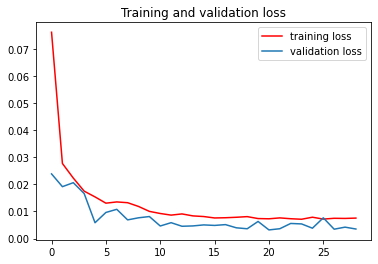

In [20]:
# Retrieve a list of list results on training and test data sets for each training epoch
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs   = range(len(loss))
# Plot training and validation loss per epoch
plt.plot(epochs,loss, color='red' , label='training loss')
plt.plot(epochs, val_loss, label='validation loss')
plt.legend()
plt.title ('Training and validation loss')

In [21]:
test_generator_with_augmentation =  DataGenerator(df_test,
                               batch_size=config.BATCH_SIZE,
                               augment=config.AUGMENT_TRAIN,
                               shuffle=False, 
                               rgb_channels=config.RGB_CHANNELS, 
                               normalize_image=config.NORMALIZE_IMAGE,
                               normalize_coordinates=config.NORMALIZE_COORDINATES,
                               scaler=train_generator.scaler)

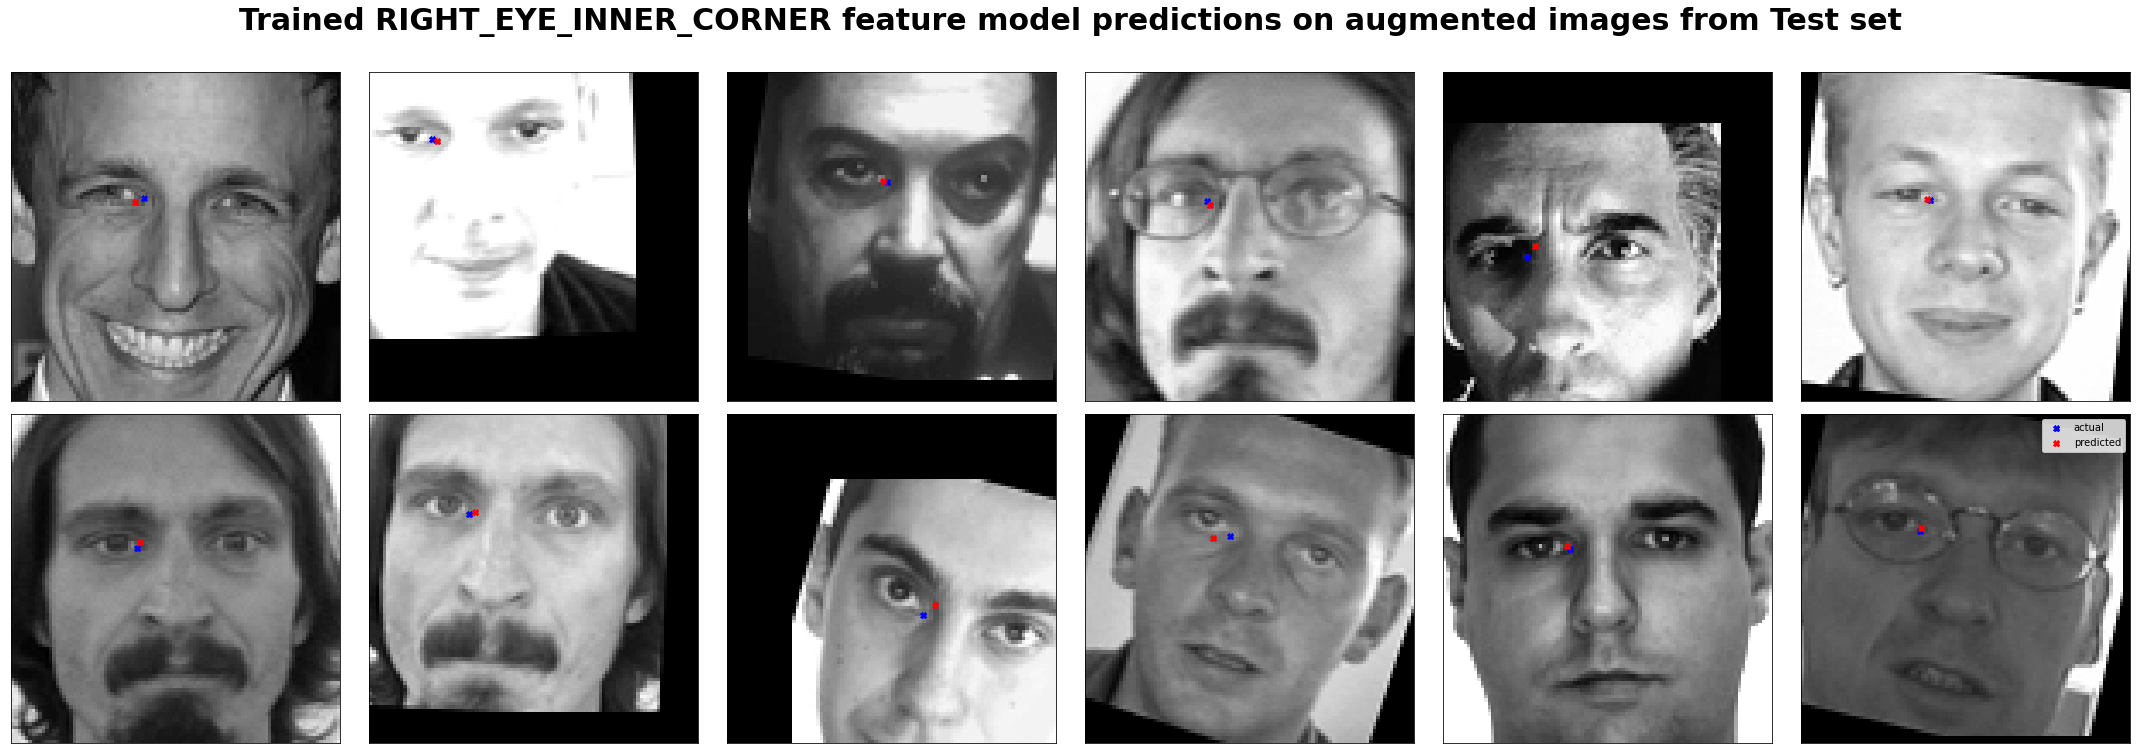

In [22]:
batch = test_generator_with_augmentation.__getitem__(1)
visualize_random_predicted_images(my_model, batch, scaler, feature_name, path+feature_name+"_augmented_results.png", "augmented")

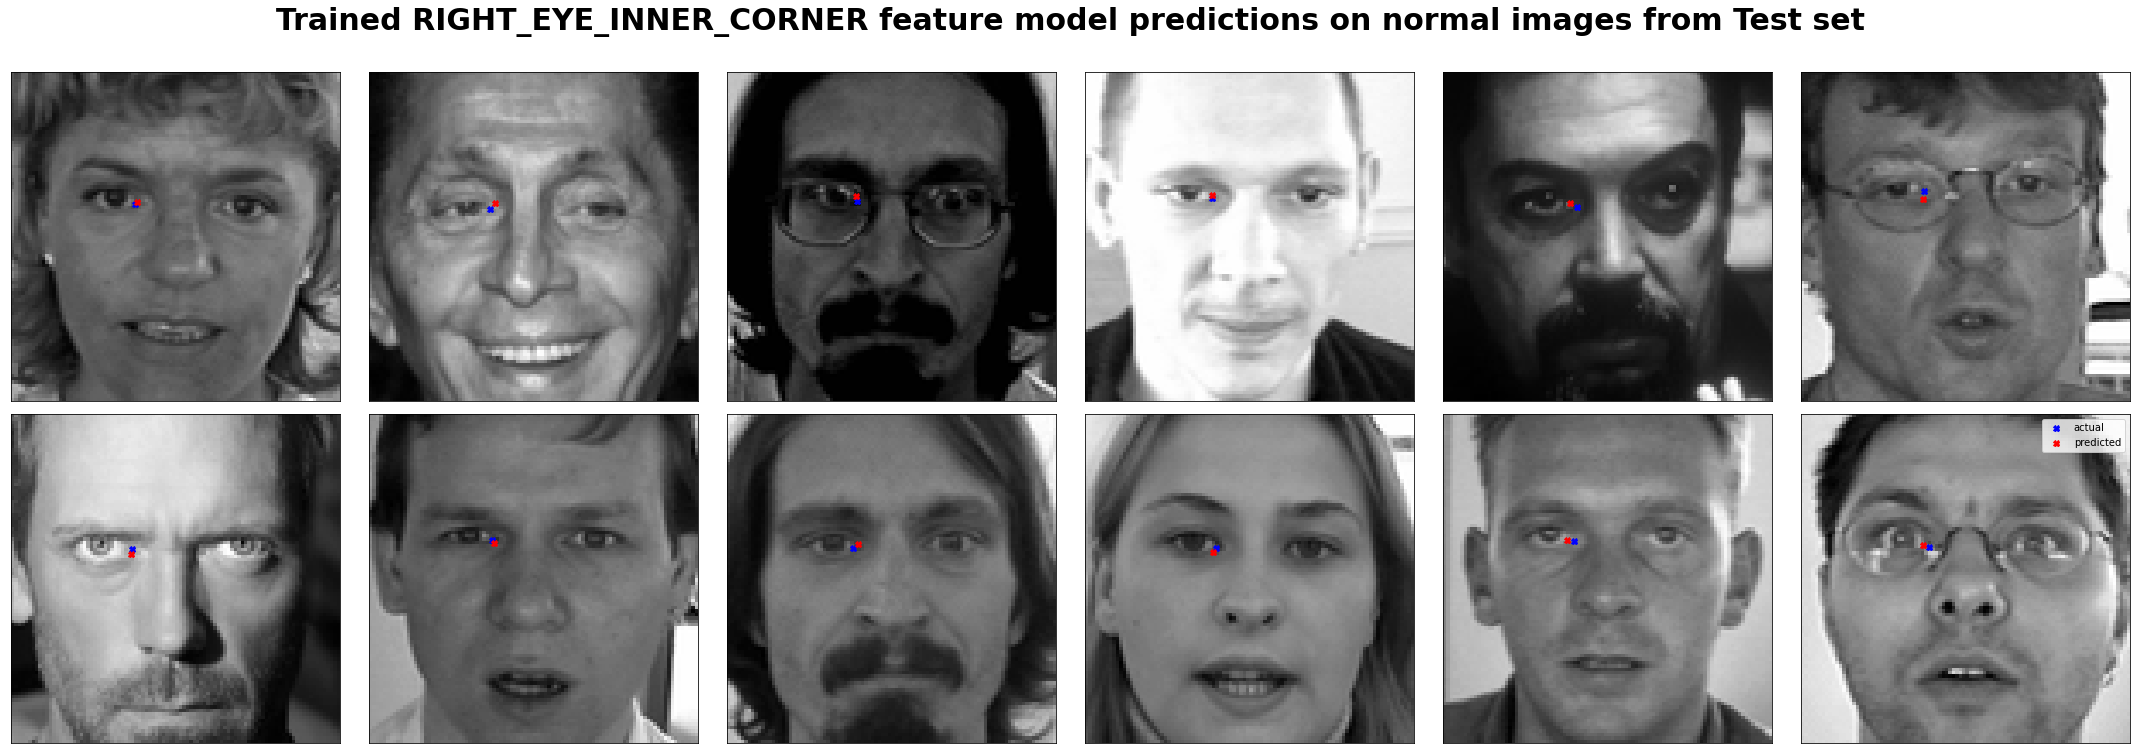

In [23]:
batch = test_generator.__getitem__(1)
visualize_random_predicted_images(my_model, batch, scaler, feature_name, path+feature_name+"_normal_results.png", "normal")